In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import subprocess
%matplotlib inline

# 冷却実験解析

In [5]:
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.util import makeMovie

In [6]:
def FFT(vmem_1d, N, dt, fc_low=None, fc_high=None):
    fq = np.linspace(0, 1.0/dt, N)
    F = np.fft.fft(vmem_1d)
    if fc_low is not None:
        F[(fq <= fc_low)] = 0
    if fc_high is not None:
        F[(fq >= fc_high)] = 0
    
    F_abs = np.abs(F)
    F_abs_amp = F_abs/N
#     F_abs_amp[0] = F_abs_amp[0]/2
    F_abs_amp[0] = 0
    
    F_ifft = np.fft.ifft(F)
    F_ifft_real = F_ifft.real * 2
    
    return F_ifft_real

## APD延長効果の確認

### 20181011-1/C001H001S0009

In [35]:
data_path = '/mnt/Jalife/ExperimentData/20181011-1/C001H001S0009/'
start = 2550
end = -1
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [36]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=start, frame_end=end)

In [37]:
raw.showFrame(0)
plt.plot(80, 40, 'o', color='black')
plt.plot(62, 80, 'o', color='blue')
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0009/raw.png', dpi=600)
plt.close()

In [100]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [9]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
vmem.morphROI(erosion=7)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], raw.data.shape[0], 0.002, fc_low=1.5, fc_high=50)

vmem.smooth(size=5)

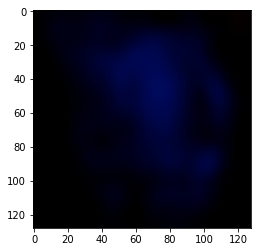

In [155]:
vmem.showFrame(frame=400)

In [10]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

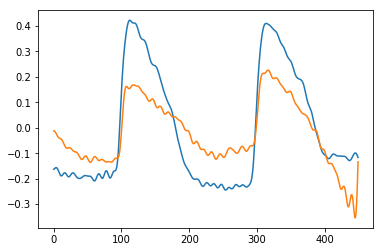

In [161]:
plt.plot(vmem.data[2000:, 40, 80])
plt.plot(vmem.data[2000:, 80, 62])

In [11]:
vmem_wo_cooling = vmem.data[2075:2250, 40, 80]
vmem_w_cooling = vmem.data[2075:2250, 80, 62]

vmem_wo_cooling = (vmem_wo_cooling-np.min(vmem_wo_cooling))/(np.max(vmem_wo_cooling) - np.min(vmem_wo_cooling))
vmem_w_cooling = (vmem_w_cooling-np.min(vmem_w_cooling))/(np.max(vmem_w_cooling) - np.min(vmem_w_cooling))

In [14]:
t = np.arange(0, 175*2, 2)
plt.plot(t, vmem_w_cooling, color='b')
plt.plot(t, vmem_wo_cooling, color='g')
plt.xlim([0, 350])
plt.ylim([0, 1])

plt.title("4150-4500ms, blue:(x,y)=(62,80), green:(x,y)=(80,40)")
plt.xlabel('Time (ms)')
plt.ylabel('Normalized membrane potential (a.u.)')


plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0009/APD.png', dpi=600)
plt.close()

### 20181009-1/C001H001S0001 (冷却なし)

In [67]:
raw = RawCam(path='/mnt/Jalife/ExperimentData/20181009-1/C001H001S0012/', cam_type='sa4',
             image_width=256, image_height=256, frame_start=3200, frame_end=3800)

In [68]:
vmem = VmemMap(raw)
vmem.smooth(size=9)
vmem.setDiffRange(diff_min=60)
vmem.morphROI(erosion=7)

for i in range(256):
    for j in range(256):
        if vmem.roi[i,j] != 0:
            vmem.data[:, i, j] = FFT(vmem.data[:, i, j], 600, 0.001, fc_low=0.5, fc_high=10)

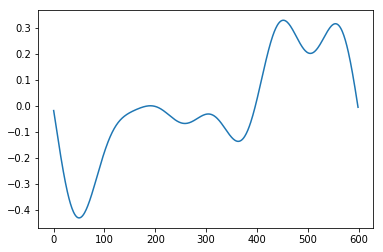

In [69]:
plt.plot(vmem.data[:, 150, 150])

In [393]:
vmem.saveImage('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181009-1/C001H001S0012/vmem/',
               img_type='png', skip=1)

In [394]:
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181009-1/C001H001S0012/')
subprocess.call(cmd, shell=True)

0

### 20181009-1/C001H001S0011 (数秒冷却)

In [ ]:
raw = RawCam(path='/mnt/Jalife/ExperimentData/20181009-1/C001H001S00/', cam_type='sa4',
             image_width=256, image_height=256, frame_start=10000, frame_end=14000)

### 20181009-1/C001H001S0013 (冷却あり)

In [17]:
raw = RawCam(path='/mnt/Jalife/ExperimentData/20181009-1/C001H001S0013/', cam_type='sa4',
             image_width=256, image_height=256, frame_start=10000, frame_end=14000)

In [29]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
vmem.morphROI(erosion=7)

for i in range(256):
    for j in range(256):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], 4000, 0.001, 0.6, 20)

vmem.smooth(size=9)

In [32]:
plt.plot(vmem.data[:, 128, 128])
plt.title("10000-14000 ms, (x,y)=(128, 128)")
plt.xlabel('Time (ms)')
plt.ylabel('Normalized membrane potential (a.u.)')
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181009-1/C001H001S0013/membrane_4000.png', dpi=600)
plt.close()

In [33]:
vmem.saveImage('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181009-1/C001H001S0013/vmem/',
               img_type='png', skip=1)

In [34]:
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181009-1/C001H001S0013/')
subprocess.call(cmd, shell=True)

0

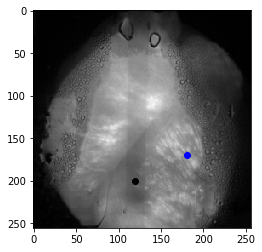

In [48]:
raw.showFrame(0)
plt.plot(119, 200, 'o', color='black')
plt.plot(180, 170, 'o', color='blue')
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181009-1/C001H001S0013/raw.png', dpi=600)
plt.close()

In [31]:
v1 = vmem.data[1700:2050, 200, 119]
v1 = (v1-np.min(v1))/(np.max(v1) - np.min(v1))
v2 = vmem.data[1700:2050, 170, 180]
v2 = (v2-np.min(v2))/(np.max(v2) - np.min(v2))

plt.plot(v1, color='b')
plt.plot(v2, color='g')
plt.xlim([0, 350])
plt.ylim([0, 1])

plt.title("11650-12100 ms, blue:(x,y)=(119,200), green:(x,y)=(180,170)")
plt.xlabel('Time (ms)')
plt.ylabel('Normalized membrane potential (a.u.)')

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181009-1/C001H001S0013/APD_long_cooling.png', dpi=600)
plt.close()

## 旋回に対する冷却

### 20181011-1/C001H001S0013 (冷却前旋回興奮)

In [13]:
raw = RawCam(path='/mnt/Jalife/ExperimentData/20181011-1/C001H001S0013/', cam_type='sa4',
             image_width=128, image_height=128, frame_start=0, frame_end=-1)

In [18]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
vmem.morphROI(erosion=7)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], 1000, 0.002, fc_high=50)

vmem.smooth(size=5)

In [19]:
vmem.saveImage('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0013/vmem/',
               img_type='png', skip=1)

In [20]:
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0013/')
subprocess.call(cmd, shell=True)

0

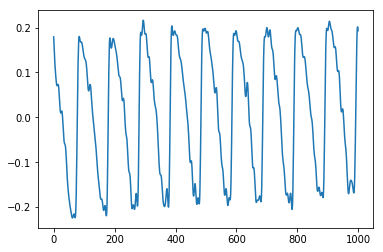

In [21]:
plt.plot(vmem.data[:, 64, 64])

In [22]:
pmap = PhaseMap(vmem, shrink=1)
pmap.saveImage('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0013/pmap', img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0013/')
subprocess.call(cmd, shell=True)

0

### 20181011-1/C001H001S0014 (冷却時: おそらく止まってない)

In [4]:
raw = RawCam(path='/mnt/Jalife/ExperimentData/20181011-1/C001H001S0014/', cam_type='sa4',
             image_width=128, image_height=128, frame_start=0, frame_end=-1)

In [5]:
raw.data.shape

(19456, 128, 128)

In [6]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
vmem.morphROI(erosion=7)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], raw.data.shape[0], 0.002, fc_low=5, fc_high=50)

vmem.smooth(size=5)

In [7]:
vmem.saveImage('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0014/vmem/',
               img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0014/')
subprocess.call(cmd, shell=True)

0

### 20181011-1/C001H001S0015 (冷却前の旋回)

In [17]:
data_path = '/mnt/Jalife/ExperimentData/20181011-1/C001H001S0015/'
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s' % (date, session_name))

In [14]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=0, frame_end=-1)

In [15]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
vmem.morphROI(erosion=7)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], raw.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=5)

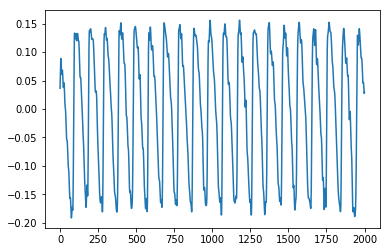

In [16]:
plt.plot(vmem.data[:, 64, 64])

In [23]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

In [25]:
pmap = PhaseMap(vmem, shrink=1)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))
    
pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

### 20181011-1/C001H001S0016 (冷却)

In [154]:
data_path = '/mnt/Jalife/ExperimentData/20181011-1/C001H001S0016/'
start = 16610
end = 17770
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [155]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=start, frame_end=end)

In [156]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
# vmem.setRectROI(top=40)
vmem.morphROI(erosion=7)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], raw.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=5)

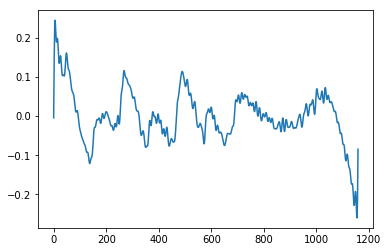

In [157]:
plt.plot(vmem.data[:, 64, 64])

In [158]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [159]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [160]:
pmap = PhaseMap(vmem, shrink=1)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))
    
pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [162]:
pvmap = PhaseVarianceMap(pmap, size=3)

if not os.path.exists(os.path.join(save_parent, 'pvmap')):
    os.makedirs(os.path.join(save_parent, 'pvmap'))
    
pvmap.saveImage(os.path.join(save_parent, 'pvmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/pvmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pvmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

### 20181011-1/C001H001S0018 (冷却)

In [164]:
data_path = '/mnt/Jalife/ExperimentData/20181011-1/C001H001S0018/'
start = 0
end = -1
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [165]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=start, frame_end=end)

In [166]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

### 20181011-1/C001H001S0019 (冷却前の旋回)

In [59]:
data_path = '/mnt/Jalife/ExperimentData/20181011-1/C001H001S0019/'
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s' % (date, session_name))

In [60]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=0, frame_end=-1)

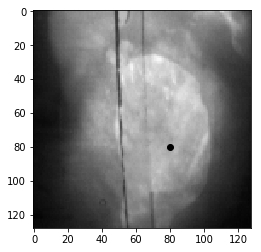

In [37]:
raw.showFrame(0)
plt.plot(80, 80, 'o', color='black')

In [12]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [61]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
vmem.morphROI(erosion=7)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], raw.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=5)

In [66]:
plt.plot(vmem.data[0:500, 64, 64])
plt.title('20181011-1/S0019 (64,64) 0-1000ms')
plt.xticks([0, 100, 200, 300, 400, 500], [0, 200, 400, 600, 800, 1000])
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0019/vmem.png', dpi=600)
plt.close()

In [10]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [9]:
pmap = PhaseMap(vmem, shrink=1)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))
    
pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

### 20181011-1/C001H001S0020 (冷却)

In [50]:
data_path = '/mnt/Jalife/ExperimentData/20181011-1/C001H001S0020/'
start = 14100
end = 15100
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [51]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=start, frame_end=end)

In [54]:
raw.showFrame(0)
plt.xticks([])
plt.yticks([])
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0020/raw.png', dpi=600)
plt.close()

In [43]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [40]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=60)
# vmem.setRectROI(top=40)
vmem.morphROI(erosion=7)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], raw.data.shape[0], 0.002, fc_low=2, fc_high=50)

vmem.smooth(size=9)

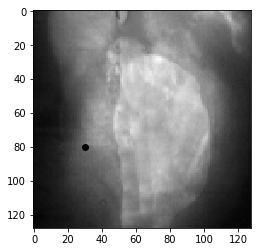

In [390]:
raw.showFrame(0)
plt.plot(30, 80, 'o', color='black')

In [58]:
range_start = 200
range_end = 700

v1 = vmem.data[range_start:range_end, 70, 30]
v1 = (v1-np.min(v1))/(np.max(v1) - np.min(v1))
v2 = vmem.data[range_start:range_end, 60, 60]
v2 = (v2-np.min(v2))/(np.max(v2) - np.min(v2))
v3 = vmem.data[range_start:range_end, 40, 80]
v3 = (v3-np.min(v3))/(np.max(v3) - np.min(v3))

plt.subplot(3,1,1)
plt.plot(v1, color='r')
plt.xlim([0, 500])
plt.ylim([0, 1])
plt.xticks([])
plt.title('r:(70, 30), b:(60, 60), g:(40, 80)')

plt.subplot(3,1,2)
plt.plot(v2, color='b')
plt.xticks([])
plt.xlim([0, 500])
plt.ylim([0, 1])

plt.subplot(3,1,3)
plt.plot(v3, color='g')
plt.xlim([0, 500])
plt.ylim([0, 1])
plt.xticks([0, 100, 200, 300, 400, 500], [0, 200, 400, 600, 800, 1000])

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0020/vmem_compare.png', dpi=600)
plt.close()

In [54]:
raw.showFrame(0)
plt.plot(30, 70, 'o', color='red')
plt.plot(60, 60, 'o', color='blue')
plt.plot(80, 40, 'o', color='green')
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181011-1/C001H001S0020/sample.png', dpi=600)
plt.close()

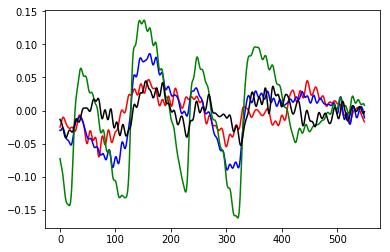

In [391]:
plt.plot(vmem.data[100:650, 80, 40], color='r')
plt.plot(vmem.data[100:650, 70, 60], color='b')
plt.plot(vmem.data[100:650, 60, 80], color='g')
plt.plot(vmem.data[100:650, 50, 100], color='black')

In [17]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [41]:
pmap = PhaseMap(vmem, shrink=1)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))
    
pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [43]:
pvmap = PhaseVarianceMap(pmap, size=3)

In [49]:
pvmap.saveImage(os.path.join(save_parent, 'pvmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/pvmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pvmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0